# Лабораторная работа №4 
# BPSK модуляция в канале АБГШ

## Описание:
В данной лабораторной работе предлагается исследовать двоичную фазовую модуляцию (BPSK) как способ передачи цифровых данных по непрерывному каналу с аддитивным белым гауссовским шумом (АБГШ).

## Ход работы:

### BPSK модуляция

BPSK (Binary Phase Shift Keying) — модуляция, при которой информация кодируется фазой несущей:

- `Бит 0` → сигнал с фазой $0^{\circ}$   (амплитуда `+1`)
- `Бит 1` → сигнал с фазой $180^{\circ}$ (амплитуда `-1`)

Эта модуляция активно используется в телекоммуникации благодаря своей симметрии и помехоустойчивости.

### Модель канала

Принятый сигнал: `r(t) = s(t) + n(t)`

где:
- `s(t)` — передаваемый BPSK сигнал ($\pm 1$)
- `n(t)` — аддитивный белый гауссовский шум
- `r(t)` — принимаемый сигнал

### Вероятность ошибки (BER)

Для BPSK в канале АБГШ:

BER = $0.5 \: erfc(\sqrt{\frac{E_b}{N_0}})$

где:
- $erfc$ — дополнительная функция ошибок, опр. как $erfc(x) = 1 - erf(x) = \frac{2}{\sqrt{\pi}} \int_x^{∞} e^{-t²} dt$

- $E_b$ — энергия на бит
- $N_0$ — спектральная плотность мощности шума

### Основные инструменты

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 11

def snr_db_to_linear(snr_db):
    return 10**(snr_db / 10)

def linear_to_db(linear):
    return 10 * np.log10(linear)

def bpsk_theoretical_ber(eb_n0_db):
    eb_n0_linear = snr_db_to_linear(eb_n0_db)
    return 0.5 * erfc(np.sqrt(eb_n0_linear))

### 1) Передача через АБГШ канал

Моделируем передачу `BPSK` сигнала через канал с белым гауссовским шумом.

Количество битов: 100
Eb/N0 значения (дБ): [ 3  5 10]



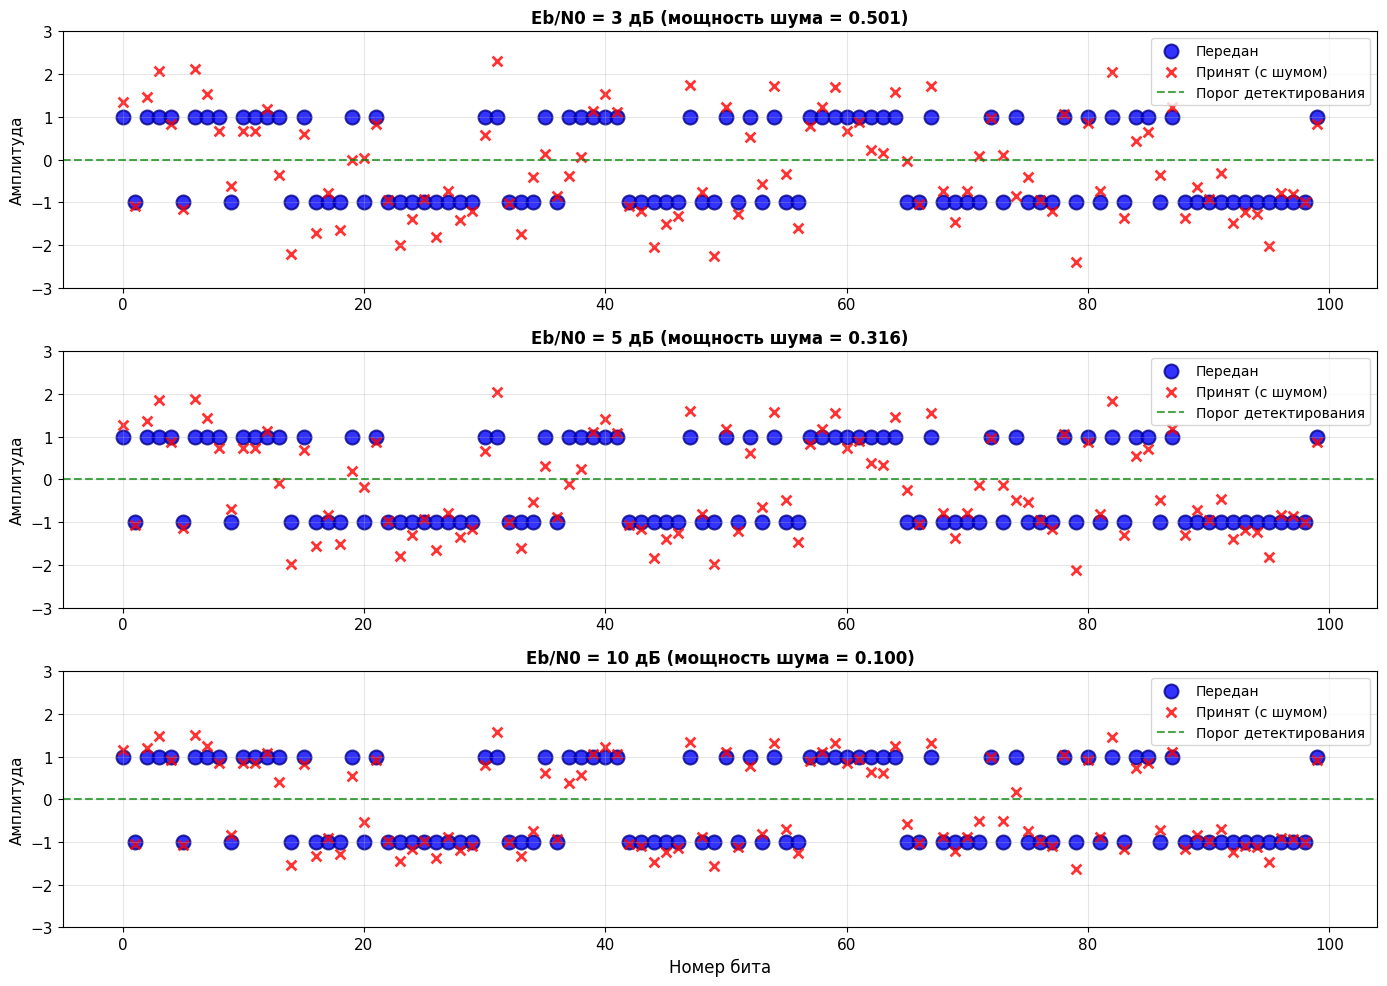

In [2]:
# Params
n_bits = 100
np.random.seed(42)
bits = np.random.randint(0, 2, n_bits)
modulated = 1 - 2 * bits

# Different Eb/N0
eb_n0_db_values = np.array([3, 5, 10])

print(f'Количество битов: {n_bits}')
print(f'Eb/N0 значения (дБ): {eb_n0_db_values}\n')

fig, axes = plt.subplots(len(eb_n0_db_values), 1, figsize=(14, 10))

for idx, eb_n0_db in enumerate(eb_n0_db_values):
    signal_power = np.mean(modulated**2)
    
    eb_n0_linear = snr_db_to_linear(eb_n0_db)
    noise_power = signal_power / eb_n0_linear
    
    # Add Gauss noise
    np.random.seed(42)
    noise = np.sqrt(noise_power) * np.random.randn(n_bits)
    received = modulated + noise
    
    # Plot
    ax = axes[idx]
    ax.scatter(range(n_bits), modulated, color='blue', s=100, 
              marker='o', label='Передан', alpha=0.8, edgecolors='darkblue', linewidth=1.5)
    ax.scatter(range(n_bits), received, color='red', s=50, 
              marker='x', label='Принят (с шумом)', alpha=0.8, linewidth=2)
    ax.axhline(y=0, color='green', linestyle='--', linewidth=1.5, 
              label='Порог детектирования', alpha=0.7)
    ax.set_ylabel('Амплитуда', fontsize=11)
    ax.set_title(f'Eb/N0 = {eb_n0_db} дБ (мощность шума = {noise_power:.3f})', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_ylim([-3, 3])

axes[-1].set_xlabel('Номер бита', fontsize=12)
plt.tight_layout()
plt.show()

По графикам видно, что при низком $\frac{E_b}{N_0}$ (`3 дБ`) - шум велик, а при высоком (`10 дБ`) - мал, что согласуется с формулой мощности шума: $\sigma^2 = \frac{P_{signal}}{E_b / N_0}$. То есть при 10 дБ данные лежат примерно в диапазоне $[-1;1]$, как и входные.

### 2) Детектирование и подсчет ошибок
Теперь смоделируем побольше битов (`1 млн`) в более широком диапазоне $\frac{E_b}{N_0}$ и будем восстанавливать их на входе при помощи порогового детектора для подсчета `BER`. В случае смоделированных данных это значение рассчитывается как отношение кол-ва ошибок к числу всех передаваемых битов.

In [3]:
eb_n0_db_values = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

n_bits_large = 1000000  # so much for the best precision
bits_large = np.random.randint(0, 2, n_bits_large)
modulated_large = 1 - 2 * bits_large

ber_simulated = []
ber_theory = []
errors_list = []

print(f'\nМоделирование на {n_bits_large} битах:')
print(f'\n{"Eb/N0":<10} {"Eb/N0":<12} {"BER":<18} {"BER":<18} {"Ошибок":<12}')
print(f'{"(дБ)":<10} {"(линейно)":<12} {"(модель)":<18} {"(теория)":<18} {"":<12}')
print('-'*90)

for eb_n0_db in eb_n0_db_values:
    signal_power = 1.0
    eb_n0_linear = snr_db_to_linear(eb_n0_db)
    noise_power = signal_power / eb_n0_linear
    
    np.random.seed(42 + int(eb_n0_db))
    noise = np.sqrt(noise_power) * np.random.randn(n_bits_large)
    received = modulated_large + noise
    
    temp = (received > 0).astype(int)
    detected = 1 - temp
    errors = np.sum(detected != bits_large)
    ber_sim = errors / n_bits_large
    ber_simulated.append(ber_sim)
    errors_list.append(errors)
    
    ber_th = bpsk_theoretical_ber(eb_n0_db)
    ber_theory.append(ber_th)
    
    print(f'{eb_n0_db:<10.0f} {eb_n0_linear:<12.2f} {ber_sim:<18.2e} {ber_th:<18.2e} {errors:<12}')


Детектирование для выбранных Eb/N0 из 2

Моделирование на 1000000 битах:

Eb/N0      Eb/N0        BER                BER                Ошибок      
(дБ)       (линейно)    (модель)           (теория)                       
------------------------------------------------------------------------------------------
0          1.00         1.59e-01           7.86e-02           158948      
1          1.26         1.31e-01           5.63e-02           130555      
2          1.58         1.04e-01           3.75e-02           104320      
3          2.00         7.83e-02           2.29e-02           78256       
4          2.51         5.68e-02           1.25e-02           56763       
5          3.16         3.75e-02           5.95e-03           37506       
6          3.98         2.30e-02           2.39e-03           22987       
7          5.01         1.26e-02           7.73e-04           12614       
8          6.31         6.07e-03           1.91e-04           6066        
9        

### 3) Кривые BER
Теперь по полученным данным построим графики кривых `BER` и ошибок для сравнения с теорией.


Расширенный диапазон для кривой: [-2 -1  0  1  2  3  4  5  6  7  8  9 10 11] дБ
Выделенные точки из 3: [ 0  1  2  3  4  5  6  7  8  9 10 11] дБ


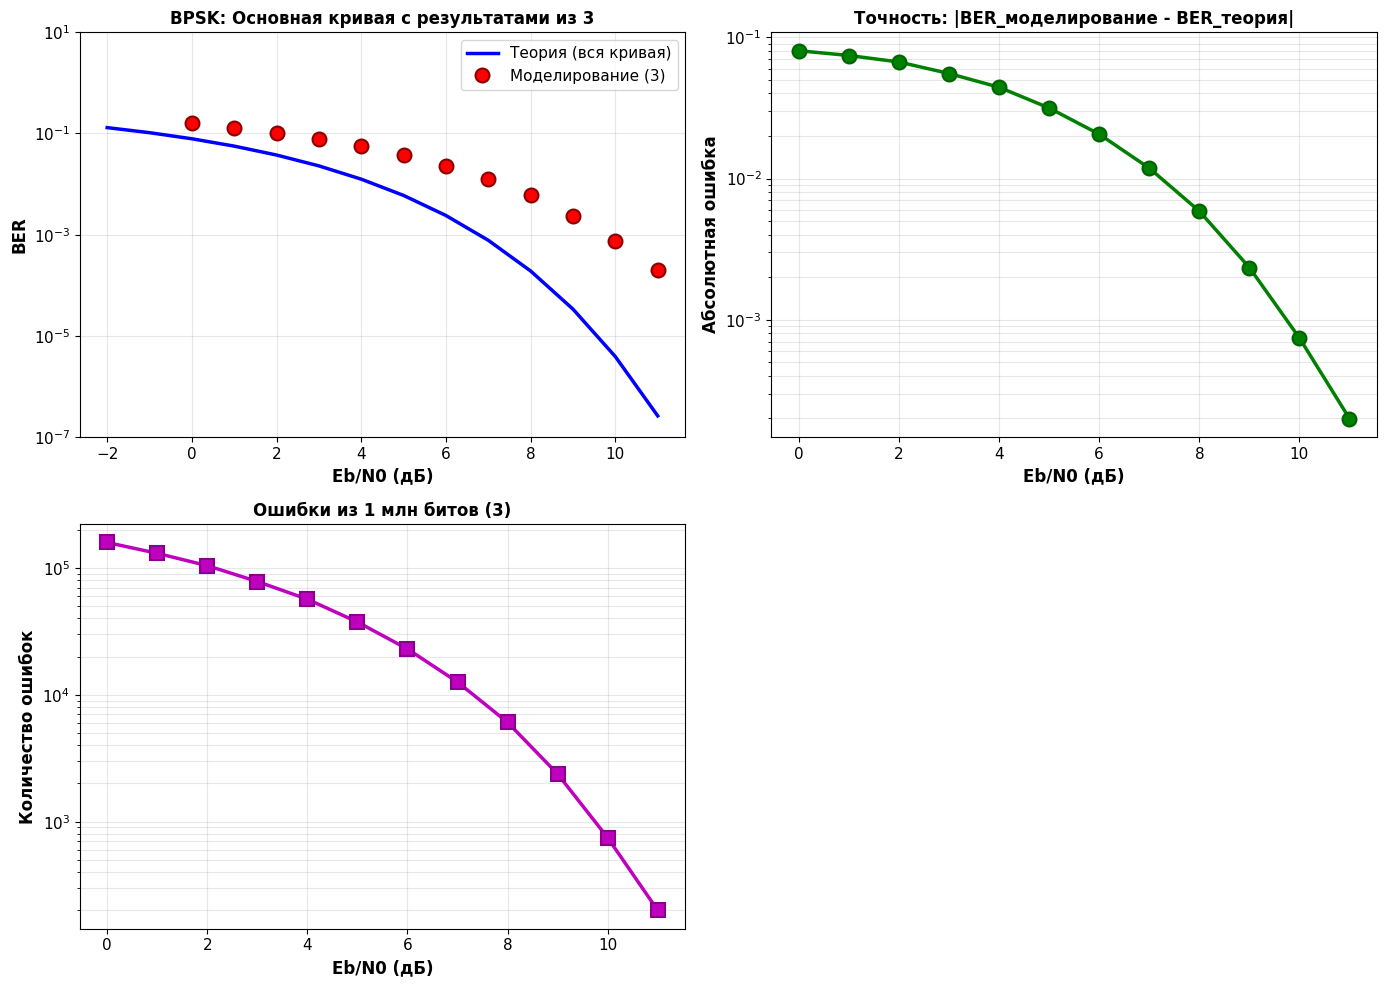

In [4]:
eb_n0_db_extended = np.arange(-2, 12, 1)
ber_theory_extended = np.array([bpsk_theoretical_ber(e) for e in eb_n0_db_extended])

print(f'\nРасширенный диапазон для кривой: {eb_n0_db_extended} дБ')
print(f'Выделенные точки из 3: {eb_n0_db_values} дБ')

# Plots
fig = plt.figure(figsize=(14, 10))

# Plot 1: BER curve
ax1 = plt.subplot(2, 2, 1)
ax1.semilogy(eb_n0_db_extended, ber_theory_extended, 'b-', linewidth=2.5, label='Теория (вся кривая)')
ax1.semilogy(eb_n0_db_values, ber_simulated, 'ro', linewidth=2.5, 
            markersize=10, label='Моделирование (2)', markeredgewidth=1.5, markeredgecolor='darkred')
ax1.set_xlabel('Eb/N0 (дБ)', fontsize=12, fontweight='bold')
ax1.set_ylabel('BER', fontsize=12, fontweight='bold')
ax1.set_title('BPSK: Основная кривая с результатами из 2', fontsize=12, fontweight='bold')
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(fontsize=11, loc='upper right')
ax1.set_ylim([1e-7, 10])

# Plot 2: Absolute errors
ax2 = plt.subplot(2, 2, 2)
absolute_errors = np.abs(np.array(ber_simulated) - np.array([bpsk_theoretical_ber(e) for e in eb_n0_db_values]))
ax2.semilogy(eb_n0_db_values, absolute_errors, 'go-', linewidth=2.5, 
            markersize=10, markeredgewidth=1.5, markeredgecolor='darkgreen')
ax2.set_xlabel('Eb/N0 (дБ)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Абсолютная ошибка', fontsize=12, fontweight='bold')
ax2.set_title('Точность: |BER_моделирование - BER_теория|', fontsize=12, fontweight='bold')
ax2.grid(True, which='both', alpha=0.3)

# Plot 3: Error number
ax3 = plt.subplot(2, 2, 3)
ax3.semilogy(eb_n0_db_values, errors_list, 'ms-', linewidth=2.5, 
            markersize=10, markeredgewidth=1.5, markeredgecolor='darkmagenta')
ax3.set_xlabel('Eb/N0 (дБ)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Количество ошибок', fontsize=12, fontweight='bold')
ax3.set_title('Ошибки из 1 млн битов (2)', fontsize=12, fontweight='bold')
ax3.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

## Выводы:
В данной лабораторной работе мы изучили двоичную фазовую модуляцию (`BPSK`), которая может применяться для передачи данных по непрерывным каналам с `АБГШ`. Мы смоделировали такую передачу вначале со `100` битами для демонстрации снижения зашумленности полученных данных при увеличении  $\frac{E_b}{N_0}$. Затем мы занялись вычислением `BER` для нашей модели (теперь было взято `1 млн` точек для лучшей точности) в более широком диапазоне  $\frac{E_b}{N_0}$ - `[0, 11] дБ`. В результате мы получили зависимость, близкую к теоретической, по которой можно сказать, что для передачи с меньшим числом ошибок следует увеличивать `SNR`, которое прямо пропорционально $\frac{E_b}{N_0}$. Таким образом, мы убедились в значимости `BPSK` в современной телекоммуникации, продемонстрировав его надежность при передаче по непрерывным каналам с гауссовским шумом.